# Классификация текстов

## Сеть прямого распространения  для классификации текстов


![title](img/mlp.png)

* $x$ - входное векторное представление текста
* $h$ – скрытые слои с нелинейными функциями активации
* $y$ – выходы, как правило, один $y$ соответствует одной метке класса 

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$h_2 = g^2(h^1 W^2 + b^2)$

$y = h^2 W^3$

### Нелинейные функции активации

![title](img/activation.png)

### Обучение сети 
### Алгоритм обратного распространения ошибки 

Ошибка: cross entropy: $\text{loss}(y_{true}, \hat{y}_{pred}) = \sum y_{true} \log(\hat{y}_{pred})$ 

1. Прямой проход:
    * вычислить $\hat{y}_{pred}$ с текущими весами на скрытых слоях
    * оценить $\text{loss}(y_{true}, \hat{y}_{pred})$

2. Обратный проход:
    * оценить  $\Delta W_h$ на каждом скрытом слое
    
    $\Delta W_h = \frac {\partial  \text{loss}}{\partial W_{H}} = \frac{\partial \text{loss}}{\partial \hat{y}_{pred}}  \frac{\partial \hat{y}_{pred}}{\partial W_{H}} $
    
    * обновление весов: $ \Delta W_H =-\eta {\frac {\partial \text{loss} } {\partial W_H} }$

### dropout-регуляризация

$NN_{MLP2}(x) = y$

$h_1 = g^1(xW^1 + b^1)$

$m^1 $~$ Bernouli(r^1)$

$\hat{h^1} = m^1 \odot h^1$

$h_2 = g^2(\hat{h^1} W^2 + b^2)$

$m^2 $~$  Bernouli(r^2)$

$\hat{h^2} = m^2 \odot h^2$

$y =\hat{h^2} W^3$



### Векторное представление текста 


1. Мешок слов [Bag of Words, BoW]
    * $|\text{word} \in V| = N$ – словарь
    * $x \in D$ – документ, $|x| = k$ 
    * $\vec{x}$ – $N$-мерный вектор, $\vec{x}_i = f(\text{word}_i, x_i)$, в котором $k$  ненулевых компонент
 

2. Распределенное представление слов [Continuous Bag of Words, CBoW])
    * one-hot кодировка: каждое слово $\text{word}$ – $N$-мерный вектор, $\overrightarrow{\text{word}}_i = 1$, иначе – 0
    * плотные вектора – эмбеддинги: каждое слово $\text{word}$ – $d$-мерный вектор, $\overrightarrow{\text{word}}_i \in \mathbb{R}$
	
    Матрица эмбеддингов: $E \in \mathbb{R}^{|V| \times d}$
	
    * $\text{CBOW}(x) = \frac{1}{k} \sum_i^k E_i $
    * $\text{x} = [\overrightarrow{\text{word}}_1  ,\ldots, \overrightarrow{\text{word}}_k ]$


#### Padding
Входные тексты имеют переменную длинну, что неудобно, поэтому предположим, что они все состоят из одинакового количества слов, только часть из этих слов – баластные символы pad.


#### Неизвестные слова (OOV)
Если в тестовом множестве встретилось неизвестное слово, то можно 
* заменить его на pad;
* заменить его на unk.  Однако в обучающем множестве unk никогда не встречается, поэтому его нужно добавить в обучающее множество искусственным образом. 


#### Word dropout - регуляризация 
Заменяем каждое слово на unk с вероятностью $\frac{\alpha}{|V| + \alpha}$


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Embedding, Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.models import Model, Sequential

import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

import random
random.seed(1228)

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report, confusion_matrix

%matplotlib inline

In [2]:
from pymystem3 import Mystem
import re
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

m = Mystem()


regex = re.compile("[А-Яа-я:=!\)\()A-z\_\%/|]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""



def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "


df_neg = pd.read_csv("data/negative.csv", sep=';', header = None, usecols = [3])
df_pos = pd.read_csv("data/positive.csv", sep=';', header = None, usecols = [3])
df_neg['sent'] = 'neg'
df_pos['sent'] = 'pos'
df = pd.concat([df_neg, df_pos])
df.columns = ['text', 'sent']
df.text = df.text.apply(words_only)
df.text = df.text.apply(lemmatize)


X = df.text.tolist()
y = df.sent.tolist()

X, y = np.array(X), np.array(y)

X_text_train, X_text_test, y_train, y_test = train_test_split(X,y, test_size=0.33)
print ("total train examples %s" % len(y_train))
print ("total test examples %s" % len(y_test))

total train examples 151978
total test examples 74856


In [3]:
TEXT_LENGTH = 10
VOCABULARY_SIZE = 20000
EMBEDDING_DIM = 100
DIMS = 250
MAX_FEATURES = 5000

batch_size = 32
nb_filter = 250
filter_length = 3
hidden_dims = 250
nb_epoch = 5

## Сеть прямого распространения

### BoW 

In [4]:
tokenizer = Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(X_text_train)
tokenizer

In [5]:
sequences = tokenizer.texts_to_sequences(X_text_train)
X_train = tokenizer.sequences_to_matrix(sequences, mode='count')
sequences = tokenizer.texts_to_sequences(X_text_test)
X_test = tokenizer.sequences_to_matrix(sequences, mode='count')

In [6]:
print('First seq:',sequences[0])
print('First doc:',X_train[0])

First seq: [191, 5, 23, 2913, 23, 104, 171, 12, 56, 1109, 1, 1403, 232, 606, 91, 12, 11, 9, 10]
First doc: [0. 0. 1. ... 0. 0. 0.]


In [7]:
le = LabelEncoder()
le.fit(['pos', 'neg'])
y_train_cat = np_utils.to_categorical(le.transform(y_train), 2)
y_test_cat = np_utils.to_categorical(le.transform(y_test), 2)

print(y_train_cat[0])

[0. 1.]


In [8]:
model = Sequential()
model.add(Dense(128, input_shape=(MAX_FEATURES,), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 136780 samples, validate on 15198 samples
Epoch 1/5
136780/136780 [==============================] - 45s 327us/step - loss: 0.5074 - acc: 0.7457 - val_loss: 0.4842 - val_acc: 0.7618
Epoch 2/5
136780/136780 [==============================] - 44s 323us/step - loss: 0.4389 - acc: 0.7945 - val_loss: 0.4815 - val_acc: 0.7711
Epoch 3/5
136780/136780 [==============================] - 48s 347us/step - loss: 0.3692 - acc: 0.8377 - val_loss: 0.5099 - val_acc: 0.7689
Epoch 4/5
136780/136780 [==============================] - 45s 331us/step - loss: 0.2882 - acc: 0.8804 - val_loss: 0.5759 - val_acc: 0.7681
Epoch 5/5
136780/136780 [==============================] - 45s 332us/step - loss: 0.2083 - acc: 0.9179 - val_loss: 0.6642 - val_acc: 0.7635


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               640128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 640,386
Trainable params: 640,386
Non-trainable params: 0
_________________________________________________________________


In [10]:
pred = model.predict_classes(X_test)
pred = le.inverse_transform(pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Precision:   0.76
Recall:   0.77
F1-measure:   0.76
Accuracy:   0.76
             precision    recall  f1-score   support

        neg       0.76      0.77      0.76     36893
        pos       0.77      0.76      0.77     37963

avg / total       0.77      0.76      0.76     74856



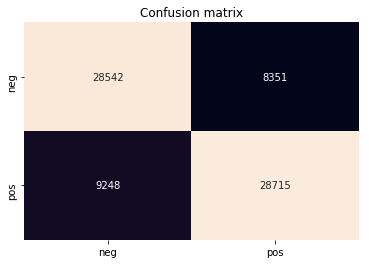

In [13]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))



sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()

### CBoW – случайно инициализированные эмбеддинги

In [14]:
sequences = tokenizer.texts_to_sequences(X_text_train)
X_train = pad_sequences(sequences, maxlen=TEXT_LENGTH)
sequences = tokenizer.texts_to_sequences(X_text_test)
X_test = pad_sequences(sequences, maxlen=TEXT_LENGTH)

In [15]:
X_train[0]

array([  14, 1210,    7,   69,   55,    2,  183,   11,    9,   10],
      dtype=int32)

In [16]:
model = Sequential()
model.add(Embedding(VOCABULARY_SIZE, EMBEDDING_DIM, input_length=TEXT_LENGTH, trainable = True))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)

Train on 136780 samples, validate on 15198 samples
Epoch 1/5
136780/136780 [==============================] - 100s 729us/step - loss: 0.5274 - acc: 0.7293 - val_loss: 0.5073 - val_acc: 0.7448
Epoch 2/5
136780/136780 [==============================] - 102s 748us/step - loss: 0.4763 - acc: 0.7674 - val_loss: 0.5129 - val_acc: 0.7378
Epoch 3/5
136780/136780 [==============================] - 93s 683us/step - loss: 0.4377 - acc: 0.7931 - val_loss: 0.5352 - val_acc: 0.7335
Epoch 4/5
136780/136780 [==============================] - 101s 739us/step - loss: 0.4116 - acc: 0.8102 - val_loss: 0.5664 - val_acc: 0.7236
Epoch 5/5
136780/136780 [==============================] - 94s 688us/step - loss: 0.3945 - acc: 0.8187 - val_loss: 0.5568 - val_acc: 0.7277


In [17]:
pred = model.predict_classes(X_test)
pred = le.inverse_transform(pred)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Precision:   0.73
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.73
             precision    recall  f1-score   support

        neg       0.72      0.73      0.73     36893
        pos       0.74      0.73      0.73     37963

avg / total       0.73      0.73      0.73     74856



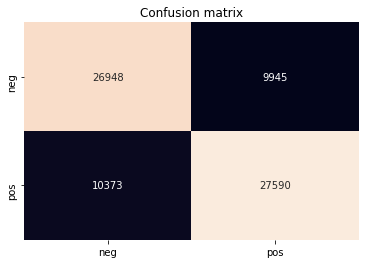

In [18]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))



sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()

### CBoW – предобученные эмбеддинги

In [19]:
%%time

import numpy as np
emb_path = '/NLP/embeddings/wiki.ru.vec'

words = []

embeddings_index = {}
f = open(emb_path)
for line in f:
    values = line.split()
    if len(values) == 301:
        word = values[0]
        words.append(word)
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

CPU times: user 4min 1s, sys: 38.5 s, total: 4min 39s
Wall time: 9min 58s


In [20]:
print(len(embeddings_index))

1775997


In [21]:
word_index = tokenizer.word_index
len(word_index)

158535

In [22]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [23]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=TEXT_LENGTH,
                            trainable=False))
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(2, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_cat, epochs=nb_epoch, batch_size=batch_size,  validation_split=0.1)


Train on 136780 samples, validate on 15198 samples
Epoch 1/5
136780/136780 [==============================] - 22s 162us/step - loss: 0.6135 - acc: 0.6604 - val_loss: 0.5937 - val_acc: 0.6780
Epoch 2/5
136780/136780 [==============================] - 20s 143us/step - loss: 0.5906 - acc: 0.6793 - val_loss: 0.5922 - val_acc: 0.6789
Epoch 3/5
136780/136780 [==============================] - 20s 144us/step - loss: 0.5861 - acc: 0.6839 - val_loss: 0.6159 - val_acc: 0.6744
Epoch 4/5
136780/136780 [==============================] - 21s 152us/step - loss: 0.5833 - acc: 0.6873 - val_loss: 0.5888 - val_acc: 0.6823
Epoch 5/5
136780/136780 [==============================] - 22s 159us/step - loss: 0.5816 - acc: 0.6885 - val_loss: 0.5877 - val_acc: 0.6859


Precision:   0.73
Recall:   0.73
F1-measure:   0.73
Accuracy:   0.73
             precision    recall  f1-score   support

        neg       0.72      0.73      0.73     36893
        pos       0.74      0.73      0.73     37963

avg / total       0.73      0.73      0.73     74856



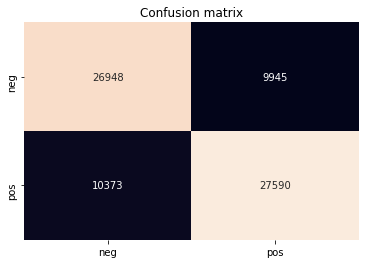

In [24]:
print("Precision: {0:6.2f}".format(precision_score(y_test, pred, average='macro')))
print("Recall: {0:6.2f}".format(recall_score(y_test, pred, average='macro')))
print("F1-measure: {0:6.2f}".format(f1_score(y_test, pred, average='macro')))
print("Accuracy: {0:6.2f}".format(accuracy_score(y_test, pred)))
print(classification_report(y_test, pred))



sns.heatmap(data=confusion_matrix(y_test, pred), annot=True, fmt="d", cbar=False, xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix")
plt.show()